Copyright © 2013 Ondrej Martinsky, All rights reserved

# Portfolio Optimization and Black-Litterman
 - Customized Strategic Asset Allocation for Global ETFs in S.Korea, edited by Yoon Soo Choi

#### Mathematical symbols used in this notebook

| Python symbol | Math Symbol | Comment
| -- | -- | --
| rf | $r$ | risk free rate
| lmb | $\lambda$ | risk aversion coefficient
| C | $C$ | Assets covariance matrix
| V | $V$ | Assets variances (diagonal in covariance matrix)
| W | $W$ | Assets weights
| R | $R$ | Assets returns
| mean | $\mu$ | Portfolio historical return
| var | $\sigma$ | Portfolio historical variance
| Pi | $\Pi$ | Portfolio equilibrium excess returns
| tau | $\tau$ | Scaling factor for Black-litterman

#### Diagram for Understanding Back-Litterman Model
- Deriving the New Combined Return Vector ($E[R]$)
![](https://drive.google.com/uc?export=view&id=1ljZAxFZ_2r5i766BVajPm4XYUyPDldLI)

(https://faculty.fuqua.duke.edu/~charvey/Teaching/BA453_2006/Idzorek_onBL.pdf)

(http://file.mk.co.kr/imss/write/20180509140802__00.pdf)

In [0]:
!pip install -U finance-datareader

In [0]:
%matplotlib inline
import scipy.optimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from datetime import datetime, date
from functools import reduce

plt.rcParams["figure.figsize"] = (13,8)
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True

## Few helper functions

#### Formula for calculating portfolio return($r_p$):

> $r_p$ = $W$⋅$R$

- $W_{n\times 1}$: vector of asset weights
- $R_{n\times 1}$: vector of corresponding asset returns.

#### Formula for calculating portfolio variance($\sigma^2_p$):

> $\sigma^2_p$ = $W$⋅$C$⋅$W$

- $C_{n\times n}$: covariance matrix of asset returns.

In [0]:
# Calculates portfolio mean return
def port_mean(W, R):
    return sum(R * W)

# Calculates portfolio variance of returns
def port_var(W, C):
    return np.dot(np.dot(W, C), W)

# Combination of the two functions above - mean and variance of returns calculation
def port_mean_var(W, R, C):
    return port_mean(W, R), port_var(W, C)

In [0]:
# Given risk-free rate, assets returns and covariances, this function calculates
# mean-variance frontier and returns its [x,y] points in two arrays
def solve_frontier(R, C, rf):
    def fitness(W, R, C, r):
        # For given level of return r, find weights which minimizes portfolio variance.
        mean, var = port_mean_var(W, R, C)
        penalty = 100 * abs(
            mean - r)  # Big penalty for not meeting stated portfolio return effectively serves as optimization constraint
        return var + penalty

    frontier_mean, frontier_var = [], []
    n = len(R)  # Number of assets in the portfolio
    for r in np.linspace(min(R), max(R), num=20):  # Iterate through the range of returns on Y axis
        W = np.ones([n]) / n  # start optimization with equal weights
#         b_ = [(0, 1) for i in range(n)]
        b_ = [(0., 0.4),(0.1,0.2),(0.,0.2),(0.,0.2),(0.,0.5),(0.,0.4),(0.05,0.4),(0.,0.15),(0.,0.15),(0.,0.2),(0.,0.2),(0.,0.2),(0.,1.)]
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
            raise BaseException(optimized.message)
        # add point to the efficient frontier [x,y] = [optimized.x, r]
        frontier_mean.append(r)
        frontier_var.append(port_var(optimized.x, C))
    return np.array(frontier_mean), np.array(frontier_var)

#### Portfolio Optimization 

Considering the starting vector of weights ($W_{n\times 1}$), the optimization process is tailored towards maximizing some kind of mean-variance utility function, such as Sharpe ratio:

> $s$=$\frac{r_{p} - r_{f} }{\sigma_{p}}$

Optimal risky portfolio with highest sharpe ratio lies on a tangency of efficient frontier with the capital market line (CML).

Given the historical asset returns $R_{n\times 1}$ and covariances $C_{n\times n}$, the optimization code using SciPy's SLSQP method may look for example as follows:

In [0]:
# Given risk-free rate, assets returns and covariances, this function calculates
# weights of tangency portfolio with respect to sharpe ratio maximization
def solve_weights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = port_mean_var(W, R, C)  # calculate mean/variance of the portfolio
        util = (mean - rf) / np.sqrt(var)  # utility = Sharpe ratio
        return 1 / util  # maximize the utility, minimize its inverse value
    n = len(R)
    W = np.ones([n]) / n  # start optimization with equal weights
#     b_ = [(0., 1.) for i in range(n)]  # weights for boundaries between 0%..100%. No leverage, no shorting
#     b_ = [(0., 0.4),(0.,0.2),(0.1,0.2),(0.,0.2),(0.,0.2),(0.,0.2),(0.,0.5),(0.,0.4),(0.05,0.4),(0.,0.15),(0.,0.15),(0.,0.2),(0.,0.2),(0.,0.2),(0.,1.)]
    b_ = [(0., 0.4),(0.1,0.2),(0.,0.2),(0.,0.2),(0.,0.5),(0.,0.4),(0.05,0.4),(0.,0.15),(0.,0.15),(0.,0.2),(0.,0.2),(0.,0.2),(0.,1.)]
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # Sum of weights must be 100%
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

In [0]:
class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var):
        self.W=W
        self.tan_mean=tan_mean
        self.tan_var=tan_var
        self.front_mean=front_mean
        self.front_var=front_var
        
def optimize_frontier(R, C, rf):
    W = solve_weights(R, C, rf)  # optimize
    tan_mean, tan_var = port_mean_var(W, R, C)  # calculate tangency portfolio
    front_mean, front_var = solve_frontier(R, C, rf)  # calculate efficient frontier
    # Weights, Tangency portfolio asset means and variances, Efficient frontier means and variances
    return Result(W, tan_mean, tan_var, front_mean, front_var)

def display_assets(names, R, C, color='black'):
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), plt.grid(True)  # draw assets
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result, label=None, color='black'):
    plt.text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
    plt.scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), plt.grid(True)
    plt.plot(result.front_var ** .5, result.front_mean, label=label, color=color), plt.grid(True)  # draw efficient frontier

## Load historical prices

In [0]:
symbols = {
    '069500': 'KODEX200', 
    '232080': 'KOSDAQ150', 
    '143850': 'S&P500', 
    '195930': 'EUROSTOXX50',
    '238720': 'Nikkei225', 
    '192090': 'CSI300', 
    '148070': 'KOSEF10yrKTB', 
    '136340': 'KBKStarCreditBond', 
    '182490': 'TIGERShortTermHighYield',
    '132030': 'KODEXGoldFutures',
    '130680': 'TIGERWTIFutures',
    '114800': 'KODEXInverse',
    '261240': 'KODEXUSDFutures',
    '261270': 'KODEXUSDFuturesInverse',
    '130730': 'KOSEFEnhancedCash',
}

cap = {
    '069500': 60.766e12, 
    '232080': 4.366e12, 
    '143850': 60.55e12, 
    '195930': 4.51118e12,
    '238720': 11.49e12, 
    '192090': 11.3729e12, 
    '148070': 456e9, 
    '136340': 666e9, 
    '182490': 268e9,
    '132030': 806e9,
    '130680': 485e9,
    '114800': 60.766e12,
    '261240': 138e9,
    '261270': 78e9,
    '130730': 471e9,
}

In [0]:
# Function loads historical stock prices of nine major S&P companies and returns them together
# with their market capitalizations, as of 2013-07-01
def load_data(symbols, cap):
    startDate = datetime(2017,4,1)
    endDate = date.today()

    df = reduce(lambda x,y: pd.merge(x,y, left_index=True, right_index=True), (fdr.DataReader(s, startDate, endDate)[['Close']].rename(columns={'Close':s}) for s in symbols))
    df.dropna(inplace=True)    
    
    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        prices = list(df[s])
        prices_out.append(prices)
        caps_out.append(cap[s])
    return df, symbols, prices_out, caps_out

assetInfo, names, prices, caps = load_data(list(symbols.keys()), cap)
n = len(names)

## Estimate assets historical return and covariances

In [0]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def assets_historical_returns_and_covariances(prices):
    prices = np.matrix(prices)  # create numpy matrix from prices
    # create matrix of historical returns
    rows, cols = prices.shape
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    # calculate returns
    expreturns = np.array([])
    for r in range(rows):
        expreturns = np.append(expreturns, np.mean(returns[r]))
    # calculate covariances
    covars = np.cov(returns)
    expreturns = (1 + expreturns) ** 250 - 1  # Annualize returns
    covars = covars * 250  # Annualize covariances
    return expreturns, covars

W = np.array(caps) / sum(caps) # calculate market weights from capitalizations
R, C = assets_historical_returns_and_covariances(prices)
rf = .0175  # Risk-free rate

##### Asset returns and weights

In [0]:
display(pd.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=names).T)

,069500,232080,143850,195930,238720,192090,148070,136340,182490,132030,130680,114800,261240,261270,130730
Return,-0.003244,0.121380,0.085429,-0.003272,0.076000,0.086698,0.042001,0.028733,0.034994,0.000513,-0.000703,0.026711,0.072302,-0.032665,0.016329
Weight (based on market cap),0.279783,0.020102,0.278788,0.020771,0.052903,0.052364,0.002100,0.003066,0.001234,0.003711,0.002233,0.279783,0.000635,0.000359,0.002169


##### Asset covariances

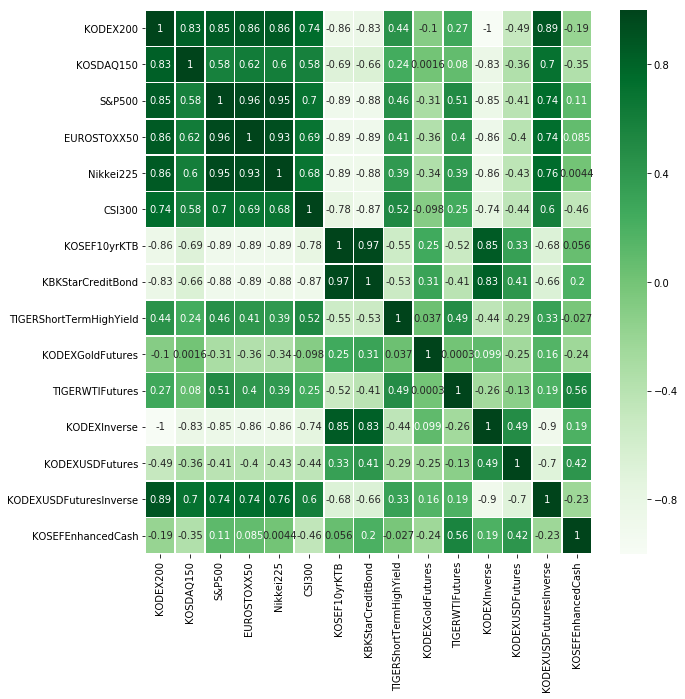

In [0]:
# display(pd.DataFrame(C, columns=names, index=names))
import seaborn as sns

# load the Auto dataset
df = pd.DataFrame(C, columns=names, index=names).rename(columns=symbols)

# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, 
        cmap="Greens",    
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True, linewidths=.5, ax=ax)

## Mean-Variance Optimization (based on historical returns)

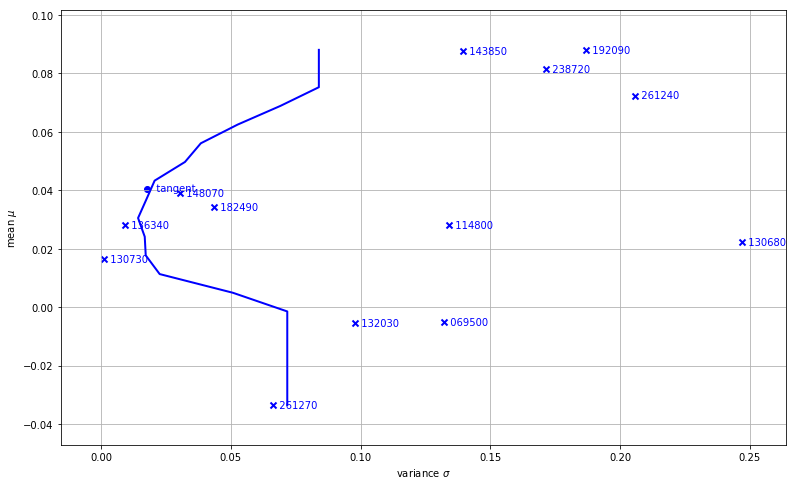

,069500,143850,238720,192090,148070,136340,182490,132030,130680,114800,261240,261270,130730
Weight,6.934123e-16,0.1,0.005882,0.028431,0.289956,0.4,0.094657,4.650176e-17,0.0,0.063898,0.017175,0.0,4.770286e-16


In [0]:
res1 = optimize_frontier(R, C, rf)

display_assets(names, R, C, color='blue')
display_frontier(res1, color='blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.show()
display(pd.DataFrame({'Weight': res1.W}, index=names).T)

## Black-litterman reverse optimization

In [0]:
# Calculate portfolio historical return and variance
mean, var = port_mean_var(W, R, C)
lmb = (mean - rf) / var  # Calculate risk aversion
Pi = np.dot(np.dot(lmb, C), W)  # Calculate equilibrium excess returns

##### Mean-variance Optimization (based on equilibrium returns)

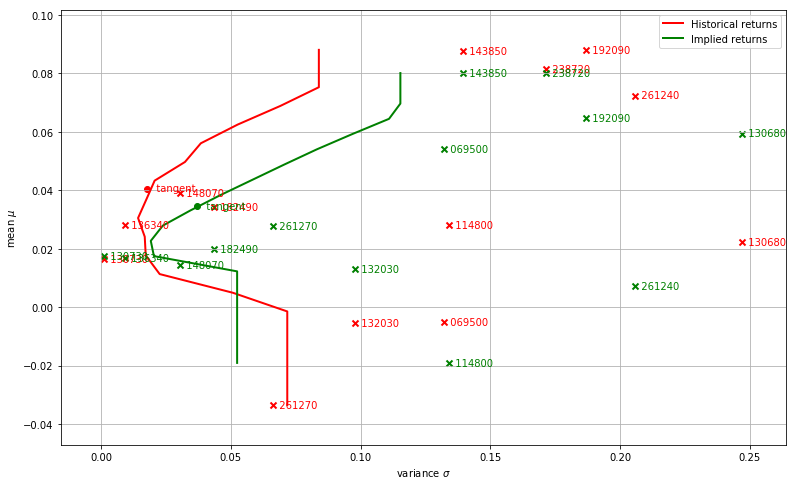

,069500,143850,238720,192090,148070,136340,182490,132030,130680,114800,261240,261270,130730
Weight,0.199091,0.2,0.040707,0.037572,0.003999,1.301043e-17,0.05,0.00047,0.001302,0.199997,0.000423,0.003403,0.263034


In [0]:
res2 = optimize_frontier(Pi+rf, C, rf)

display_assets(names, R, C, color='red')
display_frontier(res1, label='Historical returns', color='red')
display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': res2.W}, index=names).T)

##### Determine views to the equilibrium returns and prepare views (Q) and link (P) matrices

In [0]:
def create_views_and_link_matrix(names, views):
    r, c = len(views), len(names)
    Q = [views[i][3] for i in range(r)]  # view matrix
    P = np.zeros([r, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i, v in enumerate(views):
        name1, name2 = views[i][0], views[i][2]
        P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return np.array(Q), P

views = [('069500', '<', '114800', 0.05)]

Q, P = create_views_and_link_matrix(names, views)
print('Views Matrix')
display(pd.DataFrame({'Views':Q}))
print('Link Matrix')
display(pd.DataFrame(P))

Views Matrix


,Views
0,0.05


Link Matrix


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##### Optimization based on Equilibrium returns with adjusted views

$ω$ = $τ⋅P⋅C⋅P^T$

$π′$ = $[(τC)^{−1}+P^Tω^{−1}P]^{−1}⋅[(τC)^{−1}π+PTω^{−1}Q)]$

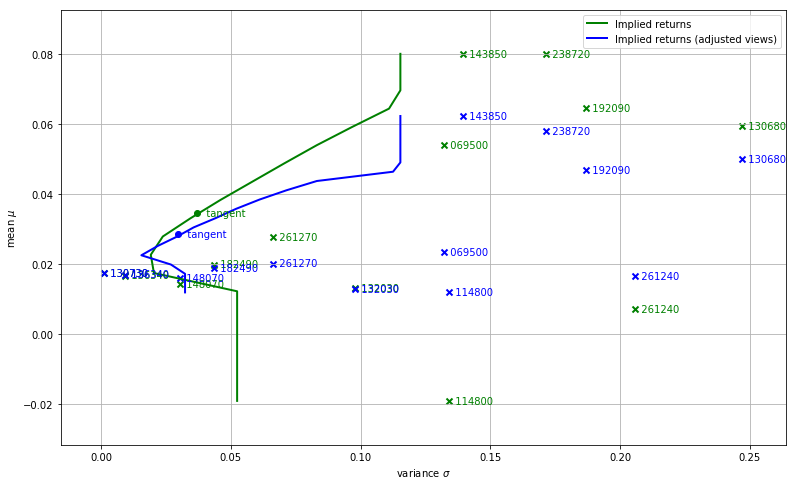

,069500,143850,238720,192090,148070,136340,182490,132030,130680,114800,261240,261270,130730
Weight,0.061619,0.2,0.039395,0.036851,0.004726,1.237139e-16,0.05,0.000505,0.001397,0.2,0.000312,0.000473,0.404721


In [0]:
tau = .025  # scaling factor

# Calculate omega - uncertainty matrix about views
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))  # 0.025 * P * C * transpose(P)
# Calculate equilibrium excess returns with views incorporated
sub_a = np.linalg.inv(np.dot(tau, C))
sub_b = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), P)
sub_c = np.dot(np.linalg.inv(np.dot(tau, C)), Pi)
sub_d = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), Q)
Pi_adj = np.dot(np.linalg.inv(sub_a + sub_b), (sub_c + sub_d))

res3 = optimize_frontier(Pi_adj + rf, C, rf)

display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
display_assets(names, Pi_adj+rf, C, color='blue')
display_frontier(res3, label='Implied returns (adjusted views)', color='blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': res3.W}, index=names).T)

####Comparison

In [0]:
BLM = assetInfo.copy()
adjWeights = pd.DataFrame({'Weight': res3.W}, index=names).T
    
for col in adjWeights.columns:
    BLM[col]= BLM[col] * float(adjWeights[col])
    
BLM['BLM'] = BLM.apply(lambda x: reduce(lambda y,z: y+z, (el for el in x)), axis=1)
BLM['BLM'] = BLM['BLM'].pct_change()
BLM.dropna(inplace=True)
    
INDEXTrend = assetInfo[['069500','143850','238720']].copy()
INDEXTrend = INDEXTrend.pct_change()
INDEXTrend.dropna(inplace=True)
INDEXTrend.rename(columns=symbols, inplace=True)

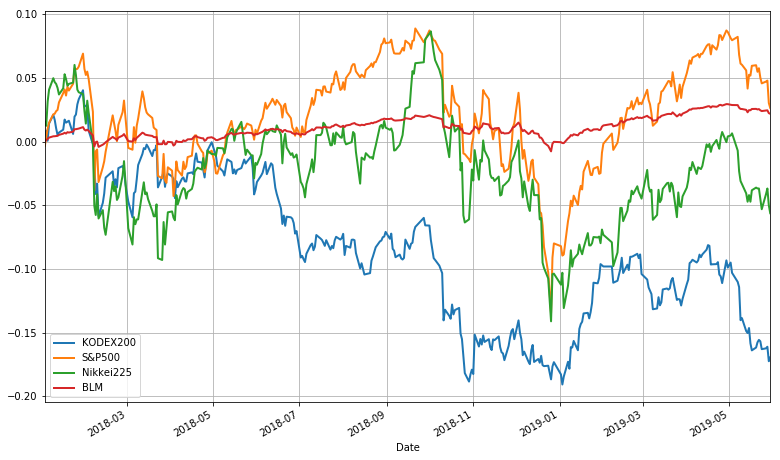

In [0]:
comparison = pd.merge(INDEXTrend, BLM, left_index=True, right_index=True).loc['2018-01-01':]
comparison = (comparison + 1).cumprod() - 1
comparison[['KODEX200', 'S&P500', 'Nikkei225', 'BLM']].plot()